# Classical Pre-processing

In [1]:
import qiskit_machine_learning
qiskit_machine_learning.__version__

'0.7.2'

In [2]:
import numpy as np # type: ignore
import tensorflow as tf # type: ignore
import torch # type: ignore
from tensorflow.keras import datasets, layers, models   # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
import time
import matplotlib.pyplot as plt # type: ignore

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from qiskit_aer import AerSimulator # type: ignore
from qiskit import QuantumCircuit, assemble, transpile # type: ignore
from qiskit.visualization import plot_histogram # type: ignore
from qiskit.providers.fake_provider import GenericBackendV2

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler

from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
 
import os
import certifi # type: ignore
os.environ['SSL_CERT_FILE'] = certifi.where()


In [3]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Randomly select 2 classes
num_classes = 10
selected_classes = np.random.choice(range(num_classes), 2, replace=False)
print(f"Selected classes: {selected_classes}")

# Filter the train and test datasets to include only the selected classes
train_mask = np.isin(y_train, selected_classes)
test_mask = np.isin(y_test, selected_classes)

x_train = x_train[train_mask.squeeze()]
y_train = y_train[train_mask.squeeze()]
x_test = x_test[test_mask.squeeze()]
y_test = y_test[test_mask.squeeze()]

idx_train = 15
idx_test = 5
x_train = x_train[:idx_train]
x_test = x_test[:idx_test]
y_train = y_train[:idx_train]
y_test = y_test[:idx_test]

# Resize images to 4x4
im_size = 4
x_train = tf.image.resize(x_train, (im_size, im_size)).numpy()
x_test = tf.image.resize(x_test, (im_size, im_size)).numpy()

# Normalize the pixel values to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode the labels for the selected classes
y_train = to_categorical(y_train, num_classes=num_classes)[:, selected_classes]
y_test = to_categorical(y_test, num_classes=num_classes)[:, selected_classes]

# Display the shapes of the processed datasets
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


Selected classes: [3 0]
(15, 4, 4, 3) (5, 4, 4, 3) (15, 2) (5, 2)


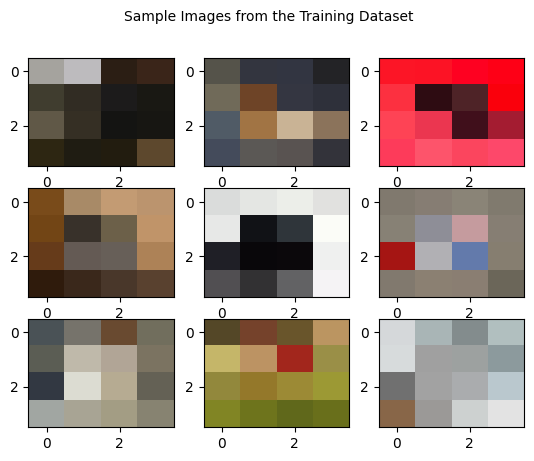

In [4]:
# visualize data by plotting images
fig, ax = plt.subplots(3, 3)
k = 0
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(x_train[k], aspect='auto')
        k += 1
plt.suptitle("Sample Images from the Training Dataset", fontsize=10)        
plt.show()

In [5]:
x_train_gray = tf.image.rgb_to_grayscale(x_train).numpy()
x_test_gray = tf.image.rgb_to_grayscale(x_test).numpy()

x_train_gray_tensor = torch.from_numpy(x_train_gray)
x_test_gray_tensor = torch.from_numpy(x_test_gray)

print(type(x_train_gray_tensor), type(x_test_gray_tensor))
print(x_train_gray_tensor.shape, x_test_gray_tensor.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([15, 4, 4, 1]) torch.Size([5, 4, 4, 1])


# Encoding 1 image

In [6]:
# # Encoding one image

# from qiskit.visualization import plot_histogram
# from qiskit.providers.fake_provider import GenericBackendV2

# image = x_train_gray_tensor[0]
# image = image.permute(2, 0, 1)  # Move channel dimension to the first position
# print(f"Permuted image size: {image.size()}")  # Should now be (1, 32, 32)

# from piqture.embeddings.image_embeddings.ineqr import INEQR # type: ignore

# # Retrieve a single image from the dataset
# image_size = tuple(image.squeeze().size())

# # Change pixel values from float to integer
# pixel_vals = (image).round().to(torch.uint8)
# pixel_vals = pixel_vals.tolist()

# embedding = INEQR(image_size, pixel_vals).ineqr()
# embedding.barrier()
# # embedding.measure_all()

# # backend = AerSimulator()
# backend = GenericBackendV2(16)
# qc_compiled = transpile(embedding,backend)
# qc_compiled.draw()


In [7]:
# # job_sim = backend.run(qc_compiled,shots=1024)
# # result_sim = job_sim.result()
# # # embedding.save_statevector()
# # outputstate = np.real(result_sim.get_statevector(qc_compiled, decimals=100))
# # outputstate

# embedding.barrier()
# # embedding.measure_all()

# # backend = AerSimulator()
# backend = GenericBackendV2(16)
# qc_compiled = transpile(embedding,backend)
# qc_compiled.save_statevector()
# # Run the transpiled circuit using the simulated fake backend
# job = backend.run(qc_compiled)
# result = job.result()
# outputstate = np.real(result.get_statevector(qc_compiled, decimals=100))
# outputstate

# Embedding the whole dataset


In [8]:

# Function to process a single image
def process_image(image):
    image = image.permute(2, 0, 1)  # Move channel dimension to the first position
    # print(f"Permuted image size: {image.size()}")  # Should now be (1, 32, 32)

    from piqture.embeddings.image_embeddings.ineqr import INEQR # type: ignore

    image_size = tuple(image.squeeze().size())

    # Change pixel values from float to integer
    pixel_vals = (image).round().to(torch.uint8)
    pixel_vals = pixel_vals.tolist()

    embedding = INEQR(image_size, pixel_vals).ineqr()
    
    return embedding

# Process all train images
train_embeddings = []
train_state_vec = []
for i in range(idx_train):
    image = x_train_gray_tensor[i]
    embedding_train = process_image(image)
    train_embeddings.append(embedding_train)
    # backend = AerSimulator()
    embedding_train.barrier()
    embedding_train.measure_all()

    # backend = AerSimulator()
    backend = GenericBackendV2(16)
    qc_compiled = transpile(embedding_train,backend)
    qc_compiled.save_statevector()
    # Run the transpiled circuit using the simulated fake backend
    job = backend.run(qc_compiled)
    result = job.result()
    outputstate_train = np.real(result.get_statevector(qc_compiled, decimals=100))
    train_state_vec.append(outputstate_train)

# Process all test images
test_embeddings = []
test_state_vec = []
for i in range(idx_test):
    image = x_test_gray_tensor[i]
    embedding_test = process_image(image)
    test_embeddings.append(embedding_test)
    embedding_test.barrier()
    embedding_test.measure_all()

    # backend = AerSimulator()

    backend = GenericBackendV2(16)
    qc_compiled = transpile(embedding_test,backend)
    qc_compiled.save_statevector()
    # Run the transpiled circuit using the simulated fake backend
    job = backend.run(qc_compiled)
    result = job.result()
    outputstate_test = np.real(result.get_statevector(qc_compiled, decimals=100))
    test_state_vec.append(outputstate_test)


print(f"Number of train image embeddings: {len(train_embeddings)}")
print(f"Number of test image embeddings: {len(test_embeddings)}")

print(f"Length of train image statevectors: {len(train_state_vec)}")
print(f"Length of test image statevectors: {len(test_state_vec)}")

# Circuit analysis of 1 image
print('Circuit dimensions')
print('Circuit depth for each image: ', train_embeddings[0].decompose().depth())
print('Circuit size for each image: ', train_embeddings[0].decompose().size())

KeyboardInterrupt: 

Above code block should be run on real ibm quantum computer. In local environment it requires a lot of time and computational resource.

# QSVM with INEQR

In [ ]:
# Convert statevectors to numpy arrays
X_train = np.array(train_state_vec)
X_test = np.array(test_state_vec)
y_train_binary = y_train.argmax(axis=1)  # Convert one-hot encoding to class labels
y_test_binary = y_test.argmax(axis=1)

X_train.shape, X_test.shape, y_train_binary.shape, y_test_binary

((15, 65536), (5, 65536), (15,), array([1, 1, 1, 0, 0]))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler # type: ignore
# Standardize the data to have a mean of 0 and variance of 1
scaler = StandardScaler()
x_train_s = scaler.fit_transform(X_train)
x_test_s = scaler.transform(X_test)

x_train_s.shape , x_test_s.shape

((15, 65536), (5, 65536))

In [ ]:
# Apply PCA for feature reduction
from sklearn.decomposition import PCA # type: ignore
n_components = 8
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_s)
x_test_pca = pca.transform(x_test_s)

# Output the shape of the reduced data
print(f"Original shape: {x_train_s.shape}")
print(f"Reduced shape: {x_train_pca.shape}")

# Optional: Show explained variance to understand the amount of information retained
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained variance by {n_components} components: {explained_variance * 100:.2f}%")

Original shape: (15, 65536)
Reduced shape: (15, 8)
Explained variance by 8 components: 78.32%


In [ ]:
# Define the quantum kernel
%time
t0 = time.time()

sampler = Sampler()  
fidelity = ComputeUncompute(sampler) 
quantum_kernel = FidelityQuantumKernel(fidelity=fidelity)

# Train the QSVM model
qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(x_train_pca, y_train.argmax(axis=1))

t1 = time.time()
print(f'Training set accuracy {qsvc.score(x_train_pca, y_train.argmax(axis=1))}')


CPU times: user 10 µs, sys: 32 µs, total: 42 µs
Wall time: 11 µs


/var/folders/px/h6cz0_fx3pz2knsspxg_65kc0000gn/T/ipykernel_40637/3365469968.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Training set accuracy 0.9333333333333333


In [ ]:
print(f"Test set accuracy: {qsvc.score(x_test_pca, y_test.argmax(axis=1))}")
t2 = time.time()

Test set accuracy: 0.6


In [ ]:
print(f"Time taken for training and testing:{t1-t0, t2-t1}")

Time taken for training and testing:(1.0630559921264648, 1.618175983428955)


# QSVM + INEQR Insights: 

1. Training set accuracy 93%
2. Testing set accuracy with SVM: 60.00%
3. Train dataset size = 15, test size = 5
4. Randomly chosen 2 classes out of 10
5. Eache image is 4x4 pizel in size
6. Train time: 1.06 s, Test time: 1.62 s